In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [8]:
# Data loading
path = r'../data/interim/data_v3_English.csv'
alzheimer_df = pd.read_csv(path)
alzheimer_df.head()

,Year,Week,Date,Entity,Epi_Year,M,F,New_Cases_Week
0,2014,2,2014-01-06,Aguascalientes,2014,0.0,0.0,0.0
1,2014,2,2014-01-06,Baja California,2014,0.0,0.0,0.0
2,2014,2,2014-01-06,Baja California Sur,2014,0.0,0.0,0.0
3,2014,2,2014-01-06,Campeche,2014,0.0,0.0,0.0
4,2014,2,2014-01-06,Chiapas,2014,0.0,0.0,0.0


## Study of inconsistencies

In [9]:
# Step 0: Create a working copy for consistency checks
alzheimer_check_df = alzheimer_df.copy()

# Step 1: Calculate cumulative sum of H and M
alzheimer_check_df['Current_MF_Sum'] = alzheimer_check_df['M'] + alzheimer_check_df['F']
alzheimer_check_df['Previous_MF_Sum'] = alzheimer_check_df.groupby('Entity')['Current_MF_Sum'].shift(1)

# Step 2: Compute the difference
alzheimer_check_df['Calculated_Difference'] = (
    alzheimer_check_df['Current_MF_Sum'] - alzheimer_check_df['Previous_MF_Sum']
)

# Step 3: Create a flag for week 2 (reset of cumulative values)
alzheimer_check_df['Its_Reset'] = alzheimer_check_df['Week'] == 2

# Step 4: For week 2, the expected difference equals the current cumulative sum
alzheimer_check_df.loc[
    alzheimer_check_df['Its_Reset'], 'Calculated_Difference'
] = alzheimer_check_df['Current_MF_Sum']

# Step 5: Verify consistency with a small tolerance
alzheimer_check_df['Consistent'] = (
    abs(alzheimer_check_df['Calculated_Difference'] - alzheimer_check_df['New_Cases_Week']) < 0.001
)

# Step 6: Filter inconsistencies (excluding the first week of each entity)
alzheimer_inconsistencias_df = alzheimer_check_df[
    ~alzheimer_check_df['Consistent'] &
    alzheimer_check_df['Previous_MF_Sum'].notna()
].copy()

# Step 7: Keep only relevant columns
columns_to_keep = ['Entity', 'Year', 'Week', 'Epi_Year', 'Week', 'M', 'F', 'New_Cases_Week', 'Calculated_Difference']
alzheimer_inconsistencias_df = alzheimer_inconsistencias_df[columns_to_keep]

# Step 8: Summary
total_checked = alzheimer_check_df['Previous_MF_Sum'].notna().sum()
total_inconsistent = len(alzheimer_inconsistencias_df)

print(f"Total records checked: {total_checked}")
print(f"Inconsistencies found: {total_inconsistent}")

Total records checked: 18272
Inconsistencies found: 680


In [10]:
alzheimer_inconsistencias_df.head(10)

,Entity,Year,Week,Epi_Year,Week,M,F,New_Cases_Week,Calculated_Difference
135,Coahuila,2014,6,2014,6,2.0,0.0,1.0,2.0
201,Durango,2014,8,2014,8,2.0,3.0,0.0,3.0
206,Michoacán,2014,8,2014,8,6.0,7.0,2.0,3.0
553,Durango,2014,19,2014,19,3.0,5.0,0.0,3.0
564,Puebla,2014,19,2014,19,1.0,3.0,1.0,2.0
646,Ciudad de México,2014,22,2014,22,25.0,34.0,5.0,6.0
779,Guerrero,2014,26,2014,26,7.0,11.0,0.0,1.0
804,Chiapas,2014,27,2014,27,11.0,12.0,1.0,4.0
813,Jalisco,2014,27,2014,27,9.0,13.0,0.0,1.0
819,Oaxaca,2014,27,2014,27,10.0,9.0,0.0,-1.0


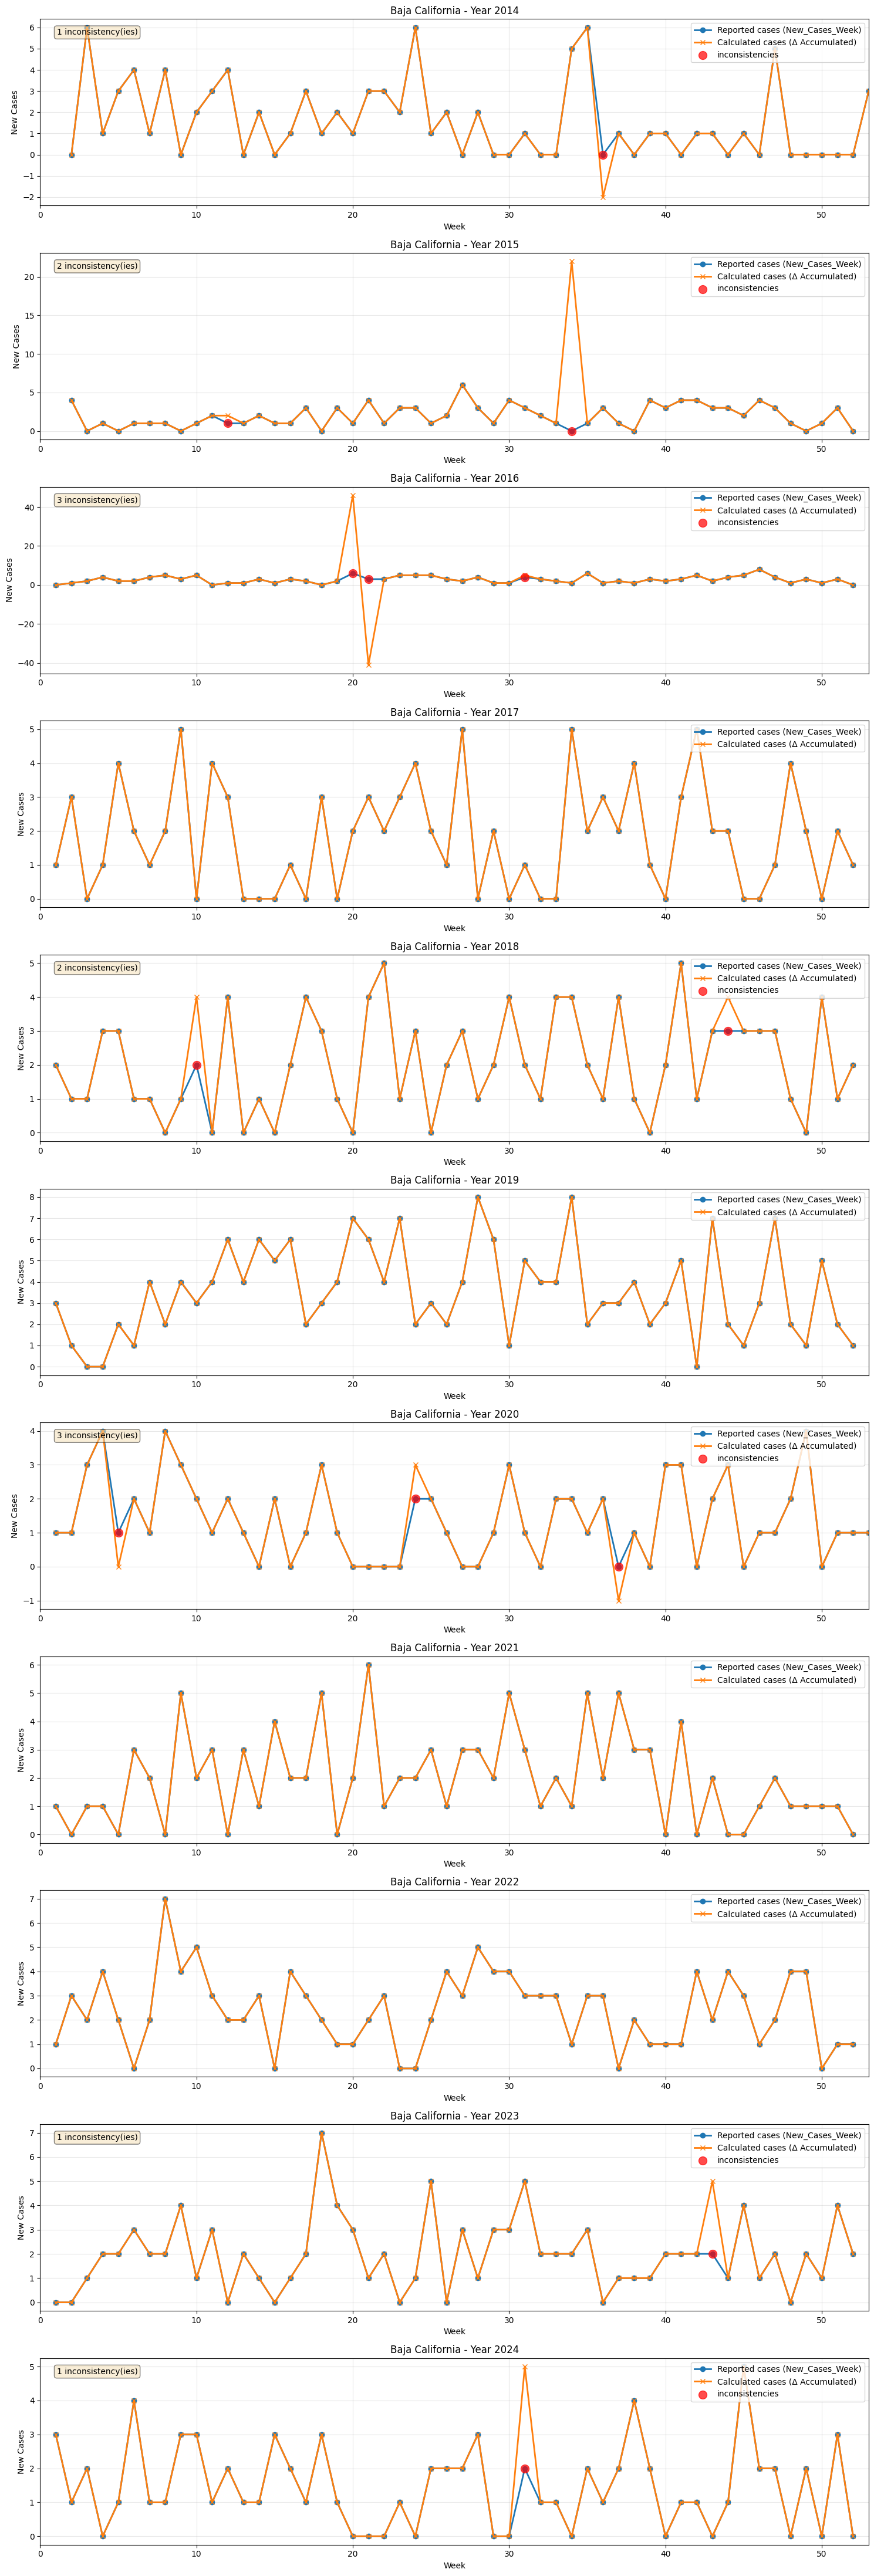

In [11]:
# Step 8: Plot comparison per entity and year
entity = 'Baja California'  # change as needed
df_entity = alzheimer_check_df[alzheimer_check_df['Entity'] == entity].copy()
years = sorted(df_entity['Year'].unique())
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(15, 4 * n_years))
if n_years == 1:
    axes = [axes]

for idx, year in enumerate(years):
    df_year = df_entity[df_entity['Year'] == year].copy()
    ax = axes[idx]

    # Plot both lines: reported vs calculated
    ax.plot(df_year['Week'], df_year['New_Cases_Week'], label='Reported cases (New_Cases_Week)', marker='o', linewidth=2)
    ax.plot(df_year['Week'], df_year['Calculated_Difference'], label='Calculated cases (Δ Accumulated)', marker='x', linewidth=2)

    # Highlight inconsistencies
    differences = abs(df_year['New_Cases_Week'] - df_year['Calculated_Difference']) > 0.001
    if differences.any():
        ax.scatter(df_year.loc[differences, 'Week'], df_year.loc[differences, 'New_Cases_Week'],
                   color='red', s=100, zorder=5, label='inconsistencies', alpha=0.7)
        n_incon = differences.sum()
        ax.text(0.02, 0.95, f'{n_incon} inconsistency(ies)',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Aesthetics
    ax.set_xlabel('Week')
    ax.set_ylabel('New Cases')
    ax.set_title(f'{entity} - Year {year}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 53)

plt.tight_layout()
plt.show()


In [ ]:
# output_folder = '../data/interim/'
# filename = 'data_inconsistencies.csv'
# route = os.path.join(output_folder, filename)


# alzheimer_inconsistencias_df.to_csv(
#     route,
#     index=False,
#     encoding='utf-8'
# )

print(alzheimer_inconsistencias_df.info())
alzheimer_inconsistencias_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 680 entries, 135 to 18291
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Entity                 680 non-null    object 
 1   Year                   680 non-null    int64  
 2   Week                   680 non-null    int64  
 3   Epi_Year               680 non-null    int64  
 4   Week                   680 non-null    int64  
 5   M                      680 non-null    float64
 6   F                      680 non-null    float64
 7   New_Cases_Week         680 non-null    float64
 8   Calculated_Difference  680 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 53.1+ KB
None


,Entity,Year,Week,Epi_Year,Week,M,F,New_Cases_Week,Calculated_Difference
135,Coahuila,2014,6,2014,6,2.0,0.0,1.0,2.0
201,Durango,2014,8,2014,8,2.0,3.0,0.0,3.0
206,Michoacán,2014,8,2014,8,6.0,7.0,2.0,3.0
553,Durango,2014,19,2014,19,3.0,5.0,0.0,3.0
564,Puebla,2014,19,2014,19,1.0,3.0,1.0,2.0
